<a href="https://colab.research.google.com/github/jjwjjwjjwjjwjjw/Koreanhandwriting/blob/main/%ED%95%9C%EA%B8%80_%EC%86%90%EA%B8%80%EC%94%A8_%EC%B5%9C%EC%A2%852.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as tr
from torch.utils.data import random_split
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.cuda.manual_seed_all(777)
print(device + " is available")

cpu is available


In [3]:
learning_rate = 0.001
batch_size = 100
num_classes = 14
epochs = 5

In [4]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # testrain2 폴더 불러오기

Saving testrain2.zip to testrain2.zip


In [ ]:
!unzip testrain2.zip -d testrain2/    #폴더 만들어 압축 풀기

In [6]:
transform = tr.Compose([
    tr.Grayscale(),  # 이미지를 흑백으로 변환
    tr.ToTensor(),  # 이미지를 Tensor로 변환
])

dataset = torchvision.datasets.ImageFolder(root="/content/testrain2/testrain2", transform=transform)

# 전체 데이터셋의 크기
dataset_size = len(dataset)

# 테스트셋의 크기 계산
test_size = int(0.2 * dataset_size)

# 훈련셋의 크기 계산
train_size = dataset_size - test_size

# 데이터셋을 무작위로 분할
train_set, test_set = random_split(dataset, [train_size, test_size])

# train_set과 test_set을 각각 DataLoader로 변환
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)


In [7]:
# input size를 알기 위해서
examples = enumerate(train_set) #열거형 객체를 생성
batch_idx, (example_data, example_targets) = next(examples) #다음 배치의 인덱스와 해당 배치의 데이터를 가져옵니다
example_data.shape

torch.Size([1, 28, 28])

In [8]:
class ConvNet(nn.Module):
  def __init__(self): # layer 정의
        super(ConvNet, self).__init__()

        # input size = 28x28 
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # input channel = 1, filter = 10, kernel size = 5, zero padding = 0, stribe = 1
        # ((W-K+2P)/S)+1 공식으로 인해 ((28-5+0)/1)+1=24 -> 24x24로 변환
        # maxpooling하면 12x12
  
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # input channel = 1, filter = 10, kernel size = 5, zero padding = 0, stribe = 1
        # ((12-5+0)/1)+1=8 -> 8x8로 변환
        # maxpooling하면 4x4

        self.drop2D = nn.Dropout2d(p=0.25, inplace=False) # 랜덤하게 뉴런을 종료해서 학습을 방해해 학습이 학습용 데이터에 치우치는 현상을 막기 위해 사용
        self.mp = nn.MaxPool2d(2)  # 오버피팅을 방지하고, 연산에 들어가는 자원을 줄이기 위해 maxpolling
        self.fc1 = nn.Linear(320,100) # 4x4x20 vector로 flat한 것을 100개의 출력으로 변경
        self.fc2 = nn.Linear(100,num_classes) # 100개의 출력을 num_classes개의 출력으로 변경

  def forward(self, x):
        x = F.relu(self.mp(self.conv1(x))) # convolution layer 1번에 relu를 씌우고 maxpool, 결과값은 12x12x10
        x = F.relu(self.mp(self.conv2(x))) # convolution layer 2번에 relu를 씌우고 maxpool, 결과값은 4x4x20
        x = self.drop2D(x)
        x = x.view(x.size(0), -1) # flat
        x = self.fc1(x) # fc1 레이어에 삽입
        x = self.fc2(x) # fc2 레이어에 삽입
        return F.log_softmax(x, dim=1) # fully-connected layer에 넣고 logsoftmax 적용

In [9]:
model = ConvNet().to(device) # CNN instance 생성
# Cost Function과 Optimizer 선택
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [10]:
print(model)

ConvNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (drop2D): Dropout2d(p=0.25, inplace=False)
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=320, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=14, bias=True)
)


In [11]:
for epoch in range(epochs): # epochs수만큼 반복

    avg_cost = 0

    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad() # 모든 model의 gradient 값을 0으로 설정
        hypothesis = model(data) # 모델을 순전파(forward pass)하여 예측(hypothesis) 결과
        cost = criterion(hypothesis, target) # 손실 함수를 사용하여 예측 결과와 실제 레이블(target) 간의 손실을 계산
        cost.backward() # backward 함수를 호출해 gradient 계산
        optimizer.step() # 모델의 학습 파라미터 갱신
        avg_cost += cost / len(train_loader) # loss 값을 변수에 누적하고 train_loader의 개수로 나눔 = 평균
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 0.808519959
[Epoch:    2] cost = 0.0835480765
[Epoch:    3] cost = 0.0411192216
[Epoch:    4] cost = 0.0260719322
[Epoch:    5] cost = 0.0201245937


In [12]:
# test
model.eval() # evaluate mode로 전환 dropout 이나 batch_normalization 해제 
with torch.no_grad(): # grad 해제 기울기계산x
    correct = 0
    total = 0
    test_cost = 0

    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        out = model(data)
        preds = torch.max(out.data, 1)[1] # 가장 높은 값을 갖는 인덱스 추출

        total += len(target) # 전체 클래스 개수 
        correct += (preds==target).sum().item() # 예측값과 실제값이 같은지 비교
        test_cost += criterion(out, target).item() * data.size(0) # 배치 크기 고려
        
    test_accuracy = 100. * correct / total
    test_loss = test_cost / total
    print('Test Accuracy: ', test_accuracy, '%')
    print('Test Loss: ', test_loss)


Test Accuracy:  99.80356850548371 %
Test Loss:  0.011404398662027915


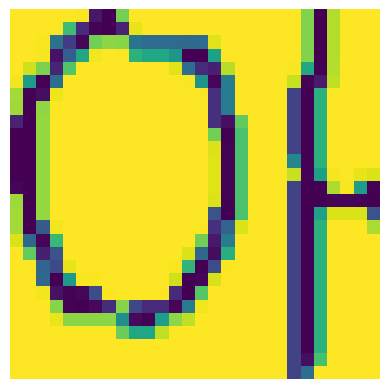

실제 라벨:  aa
예측값:  aa


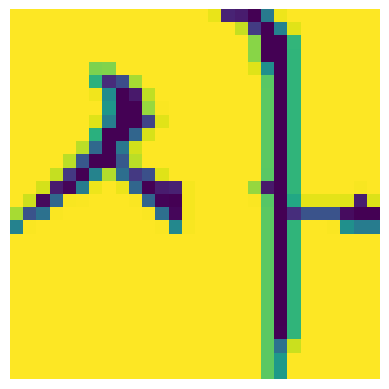

실제 라벨:  sa
예측값:  sa


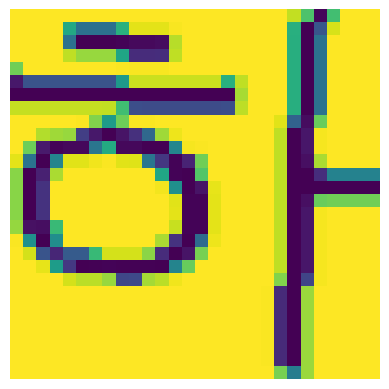

실제 라벨:  ha
예측값:  ha


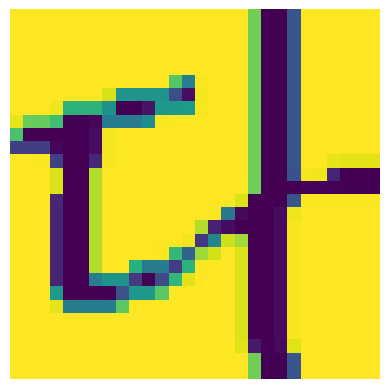

실제 라벨:  da
예측값:  da


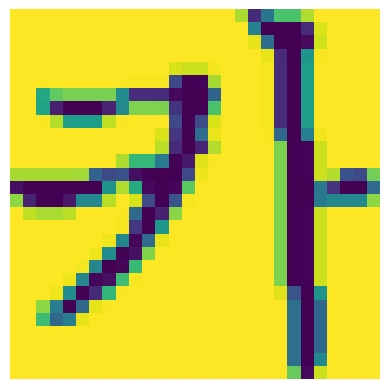

실제 라벨:  ka
예측값:  ka


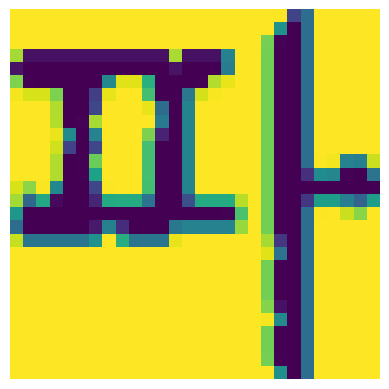

실제 라벨:  pa
예측값:  pa


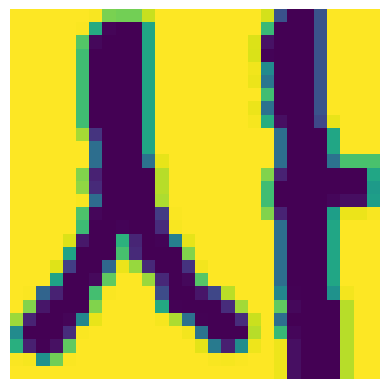

실제 라벨:  sa
예측값:  sa


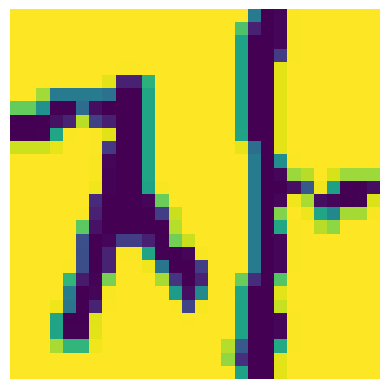

실제 라벨:  ja
예측값:  ja


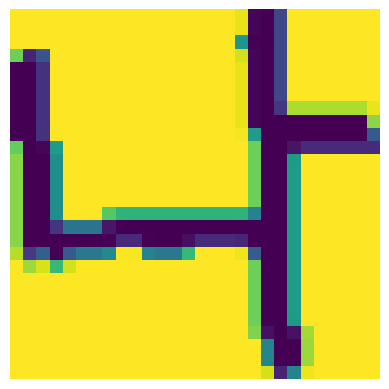

실제 라벨:  na
예측값:  na


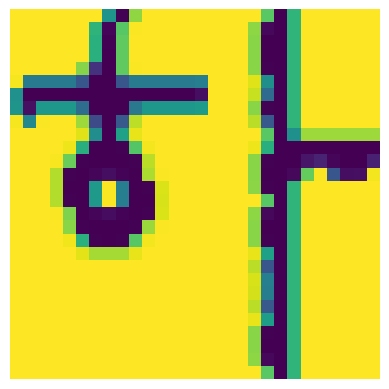

실제 라벨:  ha
예측값:  ha


In [16]:
with torch.no_grad():
    count = 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        predictions = output.argmax(dim=1)  # 가장 높은 값을 갖는 인덱스로 예측값을 얻음

        class_names = dataset.classes

        for i in range(len(data)):
            if count >= 10:
                break

            image = data[i]
            label = class_names[target[i].item()]
            prediction = class_names[predictions[i].item()]

            # 이미지 표시
            imshow(image)

            # 실제 라벨과 예측값 출력
            print('실제 라벨: ', label)
            print('예측값: ', prediction)

            count += 1

        if count >= 10:
            break
